## Note:
this is a workbook notebook for testing the baseline, lstm and cnn model... the final notebook will have much more examples and will have visualization on how the data looks

In [22]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import load_model

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [24]:
full_df.shape

(52696, 5)

In [25]:
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
df.head(10)

(5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,118718,75823,2174-06-21 00:00:00,41091 41401 2449 3320 53081 7140 51889,Admission Date: [**2174-6-18**] ...
1,153586,22878,2133-07-02 00:00:00,4280 3940 9971 42731 42732 53081,Admission Date: [**2133-6-16**] Dischar...
2,198489,40036,2141-08-09 00:00:00,0389 5849 6826 99591 4589 6953 311 7931 55092 ...,Admission Date: [**2141-8-1**] D...
3,199889,29359,2158-07-11 00:00:00,1628 5100 19889 99832 99679 49390 4019 53081,Admission Date: [**2158-6-28**] ...
4,188650,13979,2171-02-19 00:00:00,41401 4139 42731 5997 53081 71536 25060 3572,Admission Date: [**2171-2-8**] Discharg...
5,150992,55731,2127-09-03 00:00:00,4271 42822 4254 1120 2651 4280 412 4019 3051 4...,Admission Date: [**2127-8-27**] ...
6,106514,21006,2149-10-29 00:00:00,77081 7742 76517 76527 7706,Unit No: [**Numeric Identifier 65049**] Admis...
7,104983,81660,2143-04-05 00:00:00,5990 042 5793 2761 3449 0413 2768,Admission Date: [**2143-4-3**] D...
8,134831,91652,2168-06-07 00:00:00,1560 5185 5754 5070 57400 42732 25000 4019 274...,Admission Date: [**2168-5-25**] ...
9,179056,96974,2153-10-31 00:00:00,0389 51881 78552 486 42821 00845 99592 4280 41...,Admission Date: [**2153-10-21**] ...


## Pre processing ICD 9 codes

In [26]:
# instead of finding out the top 20 leave icd-9 codes and filter records based on that
# we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy
#N_TOP = 20 
#full_df, top_codes = database_selection.filter_top_codes(df, 'ICD9', N_TOP, filter_empty = True)
#df = full_df.head(1000)

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [27]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,118718,75823,2174-06-21 00:00:00,240-279 390-459 460-519 520-579 320-389 710-739,Admission Date: [**2174-6-18**] ...
1,153586,22878,2133-07-02 00:00:00,390-459 520-579 800-999,Admission Date: [**2133-6-16**] Dischar...
2,198489,40036,2141-08-09 00:00:00,240-279 001-139 680-709 390-459 290-319 520-57...,Admission Date: [**2141-8-1**] D...
3,199889,29359,2158-07-11 00:00:00,390-459 140-239 460-519 520-579 800-999,Admission Date: [**2158-6-28**] ...
4,188650,13979,2171-02-19 00:00:00,240-279 390-459 520-579 320-389 580-629 710-739,Admission Date: [**2171-2-8**] Discharg...
5,150992,55731,2127-09-03 00:00:00,001-139 240-279 390-459 290-319 320-389,Admission Date: [**2127-8-27**] ...
6,106514,21006,2149-10-29 00:00:00,760-779,Unit No: [**Numeric Identifier 65049**] Admis...
7,104983,81660,2143-04-05 00:00:00,580-629 001-139 240-279 520-579 320-389,Admission Date: [**2143-4-3**] D...
8,134831,91652,2168-06-07 00:00:00,240-279 390-459 140-239 460-519 520-579,Admission Date: [**2168-5-25**] ...
9,179056,96974,2153-10-31 00:00:00,240-279 001-139 390-459 460-519 520-579 800-99...,Admission Date: [**2153-10-21**] ...


In [28]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 4120, '240-279': 3496, '290-319': 2760, '460-519': 2491, '800-999': 2143, '580-629': 2110, '520-579': 2073, '780-789': 1651, '320-389': 1573, '001-139': 1392, '710-739': 942, '140-239': 889, '760-779': 580, '680-709': 579, '790-796': 460, '799': 154, '630-679': 19})
Number of icd9 codes in the first level that have notes in the dataset: 17


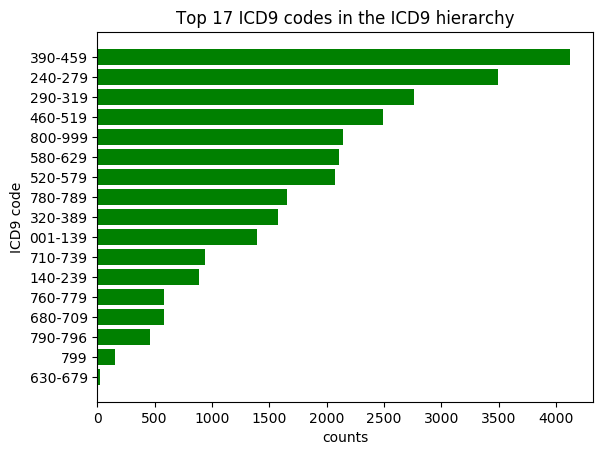

In [29]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [30]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [0 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0]


## Pre process Notes

In [31]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 45375
Average note length: 1646.18519924
Max note length: 10924
Final Vocabulary: 45375
Final Max Sequence Length: 5000


In [37]:
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX= []

In [11]:
#creating glove embeddings
EMBEDDING_LOC = '../data/glove.6B.100d.txt' # location of embedding
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True, sigma=True)


('Vocabulary in notes:', 44983)
('Vocabulary in original embedding:', 400000)
('Vocabulary intersection:', 22010)


## Split Files

In [33]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [34]:
# Delete temporary variables to free some memory
del df, data, labels

## Super Basic Baseline with top 4
Always predict top 4

In [14]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4149), ('240-279', 3476), ('290-319', 2809), ('460-519', 2481)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [15]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [17]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.532      0.526
0.030:      0.532      0.526
0.040:      0.532      0.526
0.050:      0.532      0.526
0.055:      0.532      0.526
0.058:      0.532      0.526
0.060:      0.532      0.526
0.080:      0.532      0.526
0.100:      0.532      0.526
0.200:      0.532      0.526
0.300:      0.532      0.526
0.500:      0.532      0.526


## Basic LSTM 

In [40]:
reload(lstm_model)
#### build model
l_model = lstm_model.build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 5000, 100)         4519300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 19)                1919      
Total params: 4,601,619
Trainable params: 4,601,619
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
497s - loss: 0.4698 - acc: 0.7685 - val_loss: 0.4302 - val_acc: 0.7857
Epoch 2/5
498s - loss: 0.4239 - acc: 0.7886 - val_loss: 0.4256 - val_acc: 0.7865
Epoch 3/5
528s - loss: 0.4160 - acc: 0.7946 - val_loss: 0.4173 - val_acc: 0.7941
Epoch 4/5
549s - loss: 0.4076 - acc: 0.7987 - val_loss: 0.4088 - val_acc: 0.7944
Epoch 5/5
470s - loss: 0.4017 - acc: 0.7997 - val_loss: 0.4058 - val_acc: 0.7927


In [22]:
pred_train = l_model.predict(X_train, batch_size=100)
pred_dev = l_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.501      0.506
0.030:      0.510      0.515
0.040:      0.527      0.531
0.050:      0.541      0.546
0.055:      0.550      0.554
0.058:      0.553      0.558
0.060:      0.556      0.560
0.080:      0.573      0.576
0.100:      0.585      0.588
0.200:      0.627      0.628
0.300:      0.651      0.650
0.400:      0.648      0.641
0.500:      0.606      0.585
0.600:      0.524      0.506
0.700:      0.429      0.416


## LSTM with Attention

In [41]:
import icd9_lstm_att_model

In [47]:
reload(icd9_lstm_att_model)
#### build model
l_model = icd9_lstm_att_model.build_lstm_att_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = False, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 5000, 100)     4537600     input_7[0][0]                    
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (None, 5000, 100)     80400       embedding[0][0]                  
____________________________________________________________________________________________________
permute_4 (Permute)              (None, 100, 5000)     0           lstm_5[0][0]                     
___________________________________________________________________________________________

icd9_lstm_att_model.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  max_vocab, external_embeddings, embedding_trainable, embedding_dim, embedding_matrix,


In [ ]:
h_att_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=1)

## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [15]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = False,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.9,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 5000, 100)     4498400     input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4999, 100)     20100       embedding[0][0]                  
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 4998, 100)     30100       embedding[0][0]                  
___________________________________________________________________________________________

In [51]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=20, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/20
106s - loss: 0.4133 - acc: 0.8043 - val_loss: 0.3897 - val_acc: 0.8169
Epoch 2/20
105s - loss: 0.4088 - acc: 0.8069 - val_loss: 0.3860 - val_acc: 0.8205
Epoch 3/20
105s - loss: 0.4033 - acc: 0.8102 - val_loss: 0.3810 - val_acc: 0.8236
Epoch 4/20
105s - loss: 0.4009 - acc: 0.8117 - val_loss: 0.3785 - val_acc: 0.8239
Epoch 5/20
105s - loss: 0.3968 - acc: 0.8149 - val_loss: 0.3758 - val_acc: 0.8268
Epoch 6/20
105s - loss: 0.3937 - acc: 0.8156 - val_loss: 0.3742 - val_acc: 0.8277
Epoch 7/20
105s - loss: 0.3917 - acc: 0.8183 - val_loss: 0.3724 - val_acc: 0.8291
Epoch 8/20
105s - loss: 0.3887 - acc: 0.8216 - val_loss: 0.3709 - val_acc: 0.8289
Epoch 9/20
105s - loss: 0.3875 - acc: 0.8219 - val_loss: 0.3689 - val_acc: 0.8319
Epoch 10/20
104s - loss: 0.3865 - acc: 0.8234 - val_loss: 0.3676 - val_acc: 0.8336
Epoch 11/20
105s - loss: 0.3847 - acc: 0.8251 - val_loss: 0.3658 - val_acc: 0.8363
Epoch 12/20
105s - loss: 0.3833 - acc: 0.8263 - 

In [52]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.521      0.516
0.030:      0.533      0.529
0.040:      0.545      0.541
0.050:      0.556      0.550
0.055:      0.561      0.556
0.058:      0.565      0.559
0.060:      0.567      0.562
0.080:      0.586      0.579
0.100:      0.603      0.596
0.200:      0.669      0.656
0.300:      0.711      0.695
0.400:      0.727      0.709
0.500:      0.695      0.678
0.600:      0.637      0.620
0.700:      0.560      0.540


In [54]:
model.save('models/cnn_20_epochs.h5')
#model = load_model('models/cnn_20_epochs.h5')


### only internal embedding
```
106s - loss: 0.5339 - acc: 0.7270 - val_loss: 0.4444 - val_acc: 0.7821
Epoch 2/5
105s - loss: 0.4629 - acc: 0.7703 - val_loss: 0.4295 - val_acc: 0.7891
Epoch 3/5
105s - loss: 0.4465 - acc: 0.7779 - val_loss: 0.4140 - val_acc: 0.7958
Epoch 4/5
105s - loss: 0.4309 - acc: 0.7873 - val_loss: 0.3999 - val_acc: 0.8062
Epoch 5/5
105s - loss: 0.4188 - acc: 0.7950 - val_loss: 0.3888 - val_acc: 0.8153

F1 scores
threshold | training | dev  
0.020:      0.495      0.491
0.030:      0.505      0.502
0.040:      0.515      0.512
0.050:      0.525      0.522
0.055:      0.529      0.527
0.058:      0.532      0.530
0.060:      0.533      0.532
0.080:      0.551      0.549
0.100:      0.570      0.568
0.200:      0.633      0.630
0.300:      0.659      0.656
0.400:      0.660      0.645
0.500:      0.592      0.583
0.600:      0.506      0.497
0.700:      0.365      0.361

```



### Using pre-trained Glove embedding plus internal embedding
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
105s - loss: 1.1842 - acc: 0.6948 - val_loss: 0.4606 - val_acc: 0.7826
Epoch 2/5
105s - loss: 0.6159 - acc: 0.7321 - val_loss: 0.4323 - val_acc: 0.7908
Epoch 3/5
105s - loss: 0.5112 - acc: 0.7545 - val_loss: 0.4246 - val_acc: 0.7979
Epoch 4/5
104s - loss: 0.4742 - acc: 0.7721 - val_loss: 0.4157 - val_acc: 0.8007
Epoch 5/5
104s - loss: 0.4521 - acc: 0.7795 - val_loss: 0.4084 - val_acc: 0.8014

F1 scores

threshold | training | dev  
0.020:      0.488      0.486
0.030:      0.501      0.498
0.040:      0.513      0.509
0.050:      0.522      0.519
0.055:      0.527      0.524
0.058:      0.530      0.527
0.060:      0.532      0.529
0.080:      0.550      0.546
0.100:      0.566      0.562
0.200:      0.623      0.617
0.300:      0.660      0.641
0.400:      0.660      0.627
0.500:      0.569      0.543
0.600:      0.468      0.459
0.700:      0.391      0.379
```


### Using glove 300
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
289s - loss: 1.1223 - acc: 0.6978 - val_loss: 0.4560 - val_acc: 0.7884
Epoch 2/5
286s - loss: 0.6181 - acc: 0.7385 - val_loss: 0.4200 - val_acc: 0.7989
Epoch 3/5
287s - loss: 0.5019 - acc: 0.7605 - val_loss: 0.4113 - val_acc: 0.8030
Epoch 4/5
286s - loss: 0.4624 - acc: 0.7772 - val_loss: 0.4040 - val_acc: 0.8084
Epoch 5/5
290s - loss: 0.4376 - acc: 0.7886 - val_loss: 0.3990 - val_acc: 0.8091

F1 scores
threshold | training | dev  
0.020:      0.488      0.486
0.030:      0.501      0.498
0.040:      0.513      0.509
0.050:      0.522      0.519
0.055:      0.527      0.524
0.058:      0.530      0.527
0.060:      0.532      0.529
0.080:      0.550      0.546
0.100:      0.566      0.562
0.200:      0.623      0.617
0.300:      0.660      0.641
0.400:      0.660      0.627
0.500:      0.569      0.543
0.600:      0.468      0.459
0.700:      0.391      0.379

```


## Notes:


(1) There is a LSTM model by this paper: "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records" which did achieve a 42% F1-score. (https://cs224d.stanford.edu/reports/priyanka.pdf), but it only uses the top 10 icd9 codes. We are getting 46% (just running with 1000 notes so far)


(2) The "A Comparison of Rule-Based and Deep Learning Models for Patient Phenotyping"  study did get a 70% F1-score, but they don't use the icd9-labels but phenotypes labels they annotated themselved (via a group of medical professionals). (https://arxiv.org/abs/1703.08705). There were ONLY 10 phenotypes.

The discharge summaries are labeled with ICD9-codes that are leaves in the ICD9-hierarchy (which has hundreds of ICD9-codes), then maybe these leave nodes are too specific and difficult to predict, one experiment would be to replaced all the ICD9-codes with their parent in the second or third level in the hierarchy and see if predictions work better that way.   

(3) our baseline with top 20 codes had a f1-score of 35% (assigning top 4 icd9 codes to all notes, using a CNN with no external embeddings is getting about 40% f1-score.. a little better than the baseline

(4) Papers published and best practices report  that external embeddings improve considerable the model's performance.. maybe it is not the case here because of the medical terms..   

(5) Fixed Thresholding doesn't work well for multilabel classifications, we can implement a model to choose the appropriate threshold for each record (see notes above)

(6) for loss function: binary and categorical cross entropy gave same results

In [21]:
model_hh = load_model('models/cnn_20_epochs.h5')